In [98]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [99]:
def read_data(file_path):
    # Open the file
    with open(file_path, 'r') as file:  # Use 'with' for automatic file closure

        # Split the text data into lines and remove extra whitespace
        lines = [line.strip() for line in file if line.strip()] 

        # Create a list to store data rows
        data = []

        # Process each line
        for line in lines:
            # Split the values in the line based on multiple spaces
            values = line.split()  
            
            # Convert values to floats
            values = [abs(float(val)) for val in values]

            # Add the row to the data list
            data.append(values)

    # Create a Pandas DataFrame
    column_names = [
        'absolute angle of inclination', 'angle of inclination', 'number of electrodes',
        'voltage magnitude', 'voltage frequency', 'electrode dimension',
        'x pitch', 'number of phases', 'grain mass density',
        'mesh size', 'gravity', 'phase shift', 'time step',
        'maximum classified radius', 'distance between dust generation and first electrode',
        'grain number density', 'yield'
    ]

    df = pd.DataFrame(data, columns=column_names)

    return df

def read_dataset_folder(folder_path):
    # Get a list of all files in the folder
    file_list = [f for f in os.listdir(folder_path) if f.endswith('.txt')] 

    # Create an empty list to store DataFrames
    all_dataframes = []

    # Read each file and append its DataFrame to the list
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        df = read_data(file_path)
        all_dataframes.append(df)

    # Concatenate all DataFrames into a single DataFrame
    concatenated_df = pd.concat(all_dataframes, ignore_index=True)

    concatenated_df = concatenated_df.fillna(concatenated_df.mean())

    return concatenated_df

In [100]:
Folder_name = "Dataset"
data = read_dataset_folder(Folder_name)
data

,absolute angle of inclination,angle of inclination,number of electrodes,voltage magnitude,voltage frequency,electrode dimension,x pitch,number of phases,grain mass density,mesh size,gravity,phase shift,time step,maximum classified radius,distance between dust generation and first electrode,grain number density,yield
0,335.0,25.0,4.0,500.0,5.0,3.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.014511,1.0,3.738749
1,335.0,25.0,6.0,500.0,5.0,3.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.015185,1.0,2.602313
2,335.0,25.0,8.0,500.0,5.0,3.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.015858,1.0,2.719417
3,335.0,25.0,10.0,500.0,5.0,3.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.016532,1.0,1.865867
4,335.0,25.0,4.0,500.0,5.0,4.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.014011,1.0,6.512353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8639,25.0,25.0,8.0,2000.0,20.0,3.0,20.0,4.0,4000.0,0.001,3.0,90.0,0.005,0.00001,0.065283,1.0,0.605576
8640,310.0,50.0,4.0,2000.0,20.0,6.0,40.0,4.0,3000.0,0.001,3.0,90.0,0.005,0.00001,0.035495,1.0,19.856253
8641,310.0,50.0,6.0,2000.0,20.0,6.0,40.0,4.0,3000.0,0.001,3.0,90.0,0.005,0.00001,0.032825,1.0,16.188948
8642,50.0,50.0,4.0,2000.0,20.0,6.0,40.0,4.0,3000.0,0.001,3.0,90.0,0.005,0.00001,0.143010,1.0,5.728012


In [101]:
numeric_features = ['absolute angle of inclination', 'number of electrodes', 'electrode dimension',
                    'x pitch', 'distance between dust generation and first electrode', 'voltage magnitude',
                    'voltage frequency', 'grain mass density', 'gravity']

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        features = row[numeric_features].values.astype(np.float32)
        target = row['yield'].astype(np.float32)
        return features, target

In [102]:
dataset = CustomDataset(data)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [132]:

class Net(nn.Module):
    def __init__(self, hidden_layer_size, input_size = len(numeric_features), dropout_prob=0):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [133]:
epochs = 20
train_losses = []
val_losses = []
batch_size = 8
hidden_layer_size = 32

In [134]:
def rmse_loss(outputs, targets):
    return torch.sqrt(F.mse_loss(outputs, targets.unsqueeze(1)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


model = Net(hidden_layer_size).to(device)
model = model.float()
criterion = rmse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataset.to_device = to_device
val_dataset.to_device = to_device

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Using cuda device


In [135]:
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.6f}', end=" ")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Test Loss: {val_loss:.6f}')

Epoch 1, Train Loss: 8.233519 Test Loss: 5.416215
Epoch 2, Train Loss: 6.037305 Test Loss: 5.200923
Epoch 3, Train Loss: 5.681606 Test Loss: 6.023035
Epoch 4, Train Loss: 5.609633 Test Loss: 5.344177
Epoch 5, Train Loss: 5.542215 Test Loss: 5.078228
Epoch 6, Train Loss: 5.438236 Test Loss: 5.568646
Epoch 7, Train Loss: 5.300609 Test Loss: 4.684864
Epoch 8, Train Loss: 5.222130 Test Loss: 4.659901
Epoch 9, Train Loss: 5.117963 Test Loss: 4.913432
Epoch 10, Train Loss: 5.013275 Test Loss: 4.382417
Epoch 11, Train Loss: 4.850544 Test Loss: 4.464332
Epoch 12, Train Loss: 4.829937 Test Loss: 4.489730
Epoch 13, Train Loss: 4.717376 Test Loss: 4.124628
Epoch 14, Train Loss: 4.634383 Test Loss: 5.277820
Epoch 15, Train Loss: 4.618446 Test Loss: 4.170751
Epoch 16, Train Loss: 4.579199 Test Loss: 4.424926
Epoch 17, Train Loss: 4.513163 Test Loss: 4.394961
Epoch 18, Train Loss: 4.446063 Test Loss: 4.202028
Epoch 19, Train Loss: 4.446931 Test Loss: 4.300722
Epoch 20, Train Loss: 4.417116 Test Loss

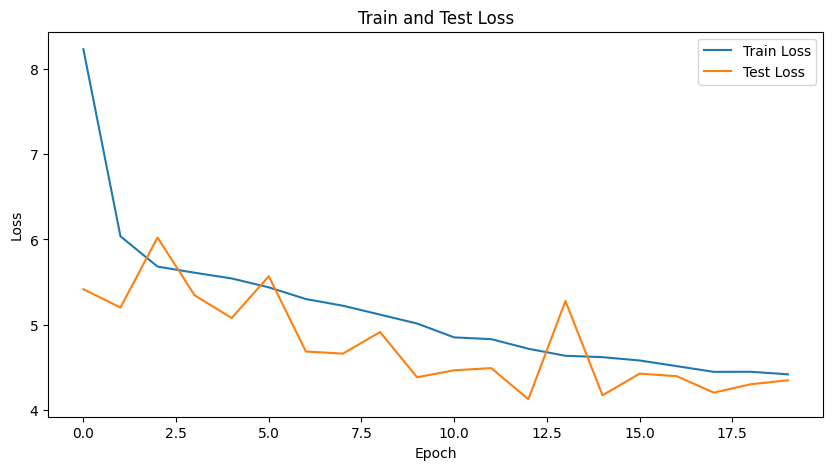

In [136]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()

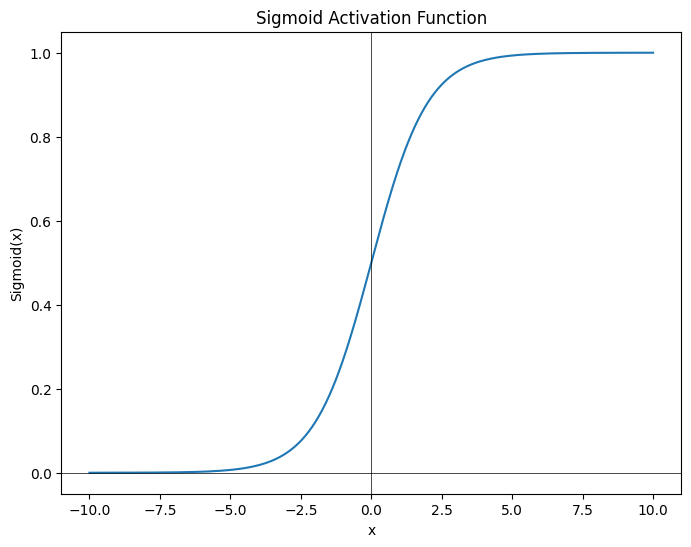

In [139]:
import torch
import matplotlib.pyplot as plt

# Create a tensor of input values
x = torch.linspace(-10, 10, 1000)

# Apply the sigmoid function
sigmoid = torch.nn.Sigmoid()
y = sigmoid(x)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x.numpy(), y.numpy(), label="Sigmoid(x)")
plt.xlabel("Input (x)")
plt.ylabel("Sigmoid(x)")
plt.title("Sigmoid Activation Function")
#plt.grid(True)
#plt.legend()
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()
